In [43]:
# Imports basics
import os
import numpy as np
import h5py
import json
import setGPU
import sklearn
import corner
import scipy
import time
from tqdm import tqdm 

# Imports neural net tools
import itertools
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
import torch.nn.functional as F
from fast_soft_sort.pytorch_ops import soft_rank
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score,  auc

In [2]:
# Opens files and reads data

print("Extracting")
outdir = 'data/IN_FlatSamples_Pytorch'
fOne = h5py.File("data/FullQCD_FullSig_Zqq_noFill_dRlimit08_50particlesordered_genMatched50.h5", 'r')
totalData = fOne["deepDoubleQ"][:]
print(totalData.shape)


Extracting
<KeysViewHDF5 ['deepDoubleQ']>
(3074667, 207)


In [3]:
# Sets controllable values

particlesConsidered = 50
particlesPostCut = 50
entriesPerParticle = 4
eventDataLength = 6
decayTypeColumn = -1
datapoints = 1400000
trainingDataLength = int(len(totalData)*0.8)
validationDataLength = int(len(totalData)*0.1)

In [4]:
# Creates Training Data

print("Preparing Data")

particleDataLength = particlesConsidered * entriesPerParticle

np.random.seed(42)
np.random.shuffle(totalData)

#trainingDataLength = int(datapoints*0.8)
#validationDataLength = int(datapoints*0.1)

mask = [i>40 for i in totalData[:, eventDataLength-1]]
totalData = totalData[mask]

labels = totalData[:, decayTypeColumn:]
particleData = totalData[:, eventDataLength:particleDataLength + eventDataLength]
eventData = totalData[:, :eventDataLength]
jetMassData = totalData[:, eventDataLength-1] #last entry in eventData (zero indexing)


######### Training Data ###############
eventTrainingData = np.array(eventData[0:trainingDataLength])
jetMassTrainingData = np.array(jetMassData[0:trainingDataLength])
particleTrainingData = np.transpose(
    particleData[0:trainingDataLength, ].reshape(trainingDataLength, 
                                                 entriesPerParticle, 
                                                 particlesConsidered),
                                                 axes=(0, 1, 2))
trainingLabels = np.array([[i, 1-i] for i in labels[0:trainingDataLength]]).reshape((-1, 2))
print(particleTrainingData.shape)

########## Validation Data ##########
eventValidationData = np.array(eventData[trainingDataLength:trainingDataLength + validationDataLength])
jetMassValidationData = np.array(jetMassData[trainingDataLength:trainingDataLength + validationDataLength])
particleValidationData = np.transpose(
    particleData[trainingDataLength:trainingDataLength + validationDataLength, ].reshape(validationDataLength,
                                                                                         entriesPerParticle,
                                                                                         particlesConsidered),
                                                                                         axes=(0, 1, 2))
validationLabels = np.array([[i, 1-i] for i in labels[trainingDataLength:trainingDataLength + validationDataLength]]).reshape((-1, 2))
print(particleValidationData.shape)


########### Testing Data ############
eventTestData = np.array(eventData[trainingDataLength + validationDataLength:])
jetMassTestData = np.array(jetMassData[trainingDataLength + validationDataLength:])
particleTestData = np.transpose(particleData[trainingDataLength + validationDataLength:,].reshape(
    len(particleData) - trainingDataLength - validationDataLength, entriesPerParticle, particlesConsidered),
                                axes=(0, 1, 2))
testLabels = np.array([[i, 1-i] for i in labels[trainingDataLength + validationDataLength:]]).reshape((-1, 2))

print('Selecting particlesPostCut')
particleTrainingData = particleTrainingData[:, :particlesPostCut]
particleValidationData = particleValidationData[:, :particlesPostCut]
particlesTestData = particleTestData[:, :particlesPostCut]

particlesConsidered = particlesPostCut


Preparing Data
(2459733, 4, 50)
(307466, 4, 50)
Selecting particlesPostCut


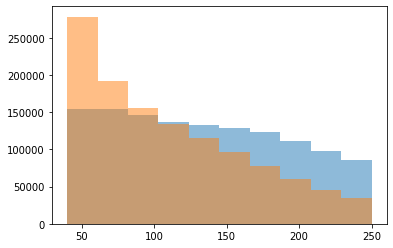

In [5]:
# Look at the data a bit!
# Jet mass for correlation
jetMassTrainingDataSig = jetMassTrainingData[trainingLabels[:,0].astype(bool)]
jetMassTrainingDataBkg = jetMassTrainingData[trainingLabels[:,1].astype(bool)]
    
plt.figure()
plt.hist(jetMassTrainingDataSig, alpha=0.5)
plt.hist(jetMassTrainingDataBkg, alpha=0.5)
#plt.hist(jetMassValidationDataSig, density=True, alpha=0.5)
#plt.hist(jetMassValidationDataBkg, density=True, alpha=0.5)
plt.show()


In [ ]:
# Defines the interaction matrices
class GraphNetnoSV(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De=5, Do=6, softmax=False):
        super(GraphNetnoSV, self).__init__()
        self.hidden = int(hidden)
        self.P = params
        self.Nv = 0 
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Nt = self.N * self.Nv
        self.Ns = self.Nv * (self.Nv - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.S = 0
        self.n_targets = n_targets
        self.assign_matrices()
        self.softmax = softmax
           
        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, self.hidden).cuda()
        self.fr2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3 = nn.Linear(int(self.hidden/2), self.De).cuda()
        self.fr1_pv = nn.Linear(self.S + self.P + self.Dr, self.hidden).cuda()
        self.fr2_pv = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3_pv = nn.Linear(int(self.hidden/2), self.De).cuda()
        
        self.fo1 = nn.Linear(self.P + self.Dx + (self.De), self.hidden).cuda()
        self.fo2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fo3 = nn.Linear(int(self.hidden/2), self.Do).cuda()
        
        self.fc_fixed = nn.Linear(self.Do, self.n_targets).cuda()
            
    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = (self.Rr).cuda()
        self.Rs = (self.Rs).cuda()

    def forward(self, x):
        ###PF Candidate - PF Candidate###
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_pp = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        

        ####Final output matrix for particles###
        

        C = torch.cat([x, Ebar_pp], 1)
        del Ebar_pp
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + (self.De))))
        C = nn.functional.relu(self.fo2(C))
        O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C

        
        #Taking the sum of over each particle/vertex
        N = torch.sum(O, dim=1)
        del O
        
        ### Classification MLP ###

        N = self.fc_fixed(N)
        
        if self.softmax:
            N = nn.Softmax(dim=1)(N)
        
        return N
            
    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])
    
class DNN(nn.Module):
    def __init__(self, n_DimLatent):
        super(DNN, self).__init__()
        #self.flat = torch.flatten()
        self.f0 = nn.Linear(200, 400).cuda()
        self.f0b = nn.Linear(400, 400).cuda()
        self.f1 = nn.Linear(400, 100).cuda()
        self.f2 = nn.Linear(100, 50).cuda()
        self.f3 = nn.Linear(50, 10).cuda()
        self.f4 = nn.Linear(10, n_DimLatent).cuda()
        self.activation = torch.nn.ReLU()
    def forward(self, x): 
        x = torch.flatten(x,start_dim=1)
        x = self.activation(self.f0(x))
        x = self.activation(self.f0b(x))
        x = self.activation(self.f1(x))
        x = self.activation(self.f2(x))
        x = self.activation(self.f3(x))
        x = self.f4(x)
        return(x)

class MLP(nn.Module):
    def __init__(self, n_inputs, n_targets):
        super(MLP, self).__init__()
        self.f1 = nn.Linear(n_inputs, n_inputs).cuda()
        self.f2 = nn.Linear(n_inputs, int(n_inputs/2)).cuda()
        self.f3 = nn.Linear(int(n_inputs/2), n_targets).cuda()
        self.activation = torch.nn.Softmax()
    def forward(self, x): 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return(self.activation(x))

class Linear(nn.Module):
    def __init__(self, n_inputs, n_targets):
        super(Linear, self).__init__()
        self.f1 = nn.Linear(n_inputs, n_targets).cuda()
        self.activation = torch.nn.Sigmoid()
    def forward(self, x): 
        x = self.f1(x)
        return(self.activation(x))

In [7]:
# Define losses 
class BarlowTwinsLoss(torch.nn.Module):

    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param
        self.device = torch.device('cuda:0')

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        #self.device = (torch.device('cuda')if z_a.is_cuda else torch.device('cpu'))
        # normalize repr. along the batch dimension
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0) # NxD
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0) # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / N # DxD
        # loss
        c_diff = (c - torch.eye(D, device=self.device)).pow(2) # DxD
        # multiply off-diagonal elems of c_diff by lambda
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
        loss = c_diff.sum()
        return loss

    
# return a flattened view of the off-diagonal elements of a square matrix
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class VICRegLoss(torch.nn.Module):

    def __init__(self, lambda_param=1,mu_param=1,nu_param=20):
        super(VICRegLoss, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        #self.device = torch.device('cpu')

    def forward(self, x, y):
        self.device = (torch.device('cuda')if x.is_cuda else torch.device('cpu'))
        
        x_scale = x
        y_scale = y
        repr_loss = F.mse_loss(x_scale, y_scale)
        
        #x = torch.cat(FullGatherLayer.apply(x), dim=0)
        #y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x_scale - x_scale.mean(dim=0)
        y = y_scale - y_scale.mean(dim=0)
        N = x_scale.size(0)
        D = x_scale.size(1)
        
        std_x = torch.sqrt(x_scale.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y_scale.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x_scale.T @ x_scale) / (N - 1)
        cov_y = (y_scale.T @ y_scale) / (N - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(D) + off_diagonal(cov_y).pow_(2).sum().div(D)

        #loss = (self.lambda_param * repr_loss + self.mu_param * std_loss+ self.nu_param * cov_loss)
        #print(repr_loss,cov_loss,std_loss)
        return repr_loss,cov_loss,std_loss
    
class CorrLoss(nn.Module):
    def __init__(self, corr=False,sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.corr      = corr
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = (pred * target).sum()
        if self.corr:
            return (1-ret)*(1-ret)
        else:
            return ret*ret 
    
    def forward(self, features, labels):
        return self.spearman(features,labels)

In [56]:
# Separate Encoder & Classifier training 

def train_encoder(encoder, batchSize, n_Dim, CorrDim, n_epochs, modelName, outdir,
                  particleTrainingData, particleValidationData, trainingLabels, jetMassTrainingData, jetMassValidationData,
                  weightrepr = 1, weightcov = 1, weightstd = 1, weightCorr1 = 0, weightCorr2 = 0):
    
    # Separating signal and bkg arrays
    particleTrainingDataSig = particleTrainingData[trainingLabels[:,0].astype(bool)]
    particleTrainingDataBkg = particleTrainingData[trainingLabels[:,1].astype(bool)]
    particleValidationDataSig = particleValidationData[validationLabels[:,0].astype(bool)]
    particleValidationDataBkg = particleValidationData[validationLabels[:,1].astype(bool)]
    particleTrainingLabelSig = trainingLabels[trainingLabels[:,0].astype(bool)]
    particleTrainingLabelBkg = trainingLabels[trainingLabels[:,1].astype(bool)]

    # Jet mass for correlation
    jetMassTrainingDataSig = jetMassTrainingData[trainingLabels[:,0].astype(bool)]
    jetMassTrainingDataBkg = jetMassTrainingData[trainingLabels[:,1].astype(bool)]
    jetMassValidationDataSig = jetMassValidationData[validationLabels[:,0].astype(bool)]
    jetMassValidationDataBkg = jetMassValidationData[validationLabels[:,1].astype(bool)]
    
    
    try: 
        os.mkdir(outdir) 
    except OSError as error: 
        print(error)
    clr_criterion  = VICRegLoss(lambda_param=1,mu_param=1,nu_param=1)
    cor_criterion  = CorrLoss()
    acr_criterion  = CorrLoss(corr=True)

    optimizer = optim.Adam(encoder.parameters(), lr = 0.0001)
    loss_vals_training = np.zeros(n_epochs)
    loss_vals_validation = np.zeros(n_epochs)

    final_epoch = 0
    l_val_best = 99999

    for m in range(n_epochs):
        print("Epoch %s\n" % m)
        #torch.cuda.empty_cache()
        final_epoch = m
        lst = []
        loss_val = []
        loss_training = []
        correct = []
        tic = time.perf_counter()

        particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
        particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
        particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                    jetMassValidationDataSig)
        particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                    jetMassValidationDataBkg)


        for i in tqdm(range(int(0.8*datapoints/batchSize))): 
            optimizer.zero_grad()

            # Define validation events
            trainingvSig = torch.FloatTensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
            trainingvBkg = torch.FloatTensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
            trainingvMassSig = torch.FloatTensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
            trainingvMassBkg = torch.FloatTensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
            trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                    trainingvBkg[:int(batchSize/2)]))
            trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                    trainingvMassBkg[:int(batchSize/2)]))
            trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                    trainingvBkg[int(batchSize/2):]))
            trainingv2_mass = torch.cat((trainingvMassSig[int(batchSize/2):], 
                                    trainingvMassBkg[int(batchSize/2):]))

            # Calculate network output
            out1 = encoder(trainingv1)
            out2 = encoder(trainingv2)

            #VICReg Loss
            repr_loss, cov_loss, std_loss = clr_criterion(out1, out2)

            l = weightrepr*repr_loss + weightcov*cov_loss + weightstd*std_loss

            '''
            # For Clara: these can be commented out if not in use to make things run faster
            # Anti-Correlation (actually correlation)
            for dim in range(CorrDim): 
                l += weightCorr1*(dim+1)*acr_criterion(trainingv1_mass, out1[:,dim])
                l += weightCorr1*(dim+1)*acr_criterion(trainingv2_mass, out2[:,dim])

            # Correlation for rest of dimensions (anti-correlation)
            #for dim in range(1): 
            for dim in range(out1.shape[1]-CorrDim): 
                l += weightCorr2*(dim+1)*cor_criterion(out1[:,dim+CorrDim], trainingv1_mass)
                l += weightCorr2*(dim+1)*cor_criterion(out2[:,dim+CorrDim], trainingv2_mass)
            '''

            loss_training.append(l.item())
            l.backward()
            optimizer.step()
            loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
            del trainingvSig, trainingvBkg, trainingv1_mass, trainingv2_mass, trainingv1, trainingv2, out1, out2
            torch.cuda.empty_cache()

        toc = time.perf_counter()
        print(f"Training done in {toc - tic:0.4f} seconds")
        tic = time.perf_counter()

        out_val_total_sig = []
        out_val_total_bkg = []
        out_val_mass_total_sig = []
        out_val_mass_total_bkg = []

        for i in range(int(0.1*datapoints/(batchSize))):
            torch.cuda.empty_cache()

            # Define validation events
            trainingvSig_val = torch.FloatTensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
            trainingvBkg_val = torch.FloatTensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
            trainingvMassSig_val = torch.FloatTensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
            trainingvMassBkg_val = torch.FloatTensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
            targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
            trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
            trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
            trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                    trainingvMassBkg_val[:int(batchSize/2)]))
            trainingv2_val_mass = torch.cat((trainingvMassSig_val[int(batchSize/2):], 
                                    trainingvMassBkg_val[int(batchSize/2):]))


            # For use in making plots later in epoch
            out_val_total_sig.append(encoder(trainingvSig_val).cpu().detach().numpy())
            out_val_mass_total_sig.append(trainingvMassSig_val.cpu().detach().numpy())
            out_val_total_bkg.append(encoder(trainingvBkg_val).cpu().detach().numpy())
            out_val_mass_total_bkg.append(trainingvMassBkg_val.cpu().detach().numpy())

            # VICReg Loss
            out1_val = encoder(trainingv1_val)
            out2_val = encoder(trainingv2_val)
            repr_loss, cov_loss, std_loss = clr_criterion(out1_val, out2_val)

            l_val = weightrepr*repr_loss + weightcov*cov_loss + weightstd*std_loss

            '''
            # For Clara: these can be commented out if not in use to make things run faster
            # AntiCorrelation
            for dim in range(CorrDim): 
                l_val += weightCorr1*(dim+1)*acr_criterion(trainingv1_val_mass, out1_val[:,dim])
                l_val += weightCorr1*(dim+1)*acr_criterion(trainingv2_val_mass, out2_val[:,dim])

            # Correlation for rest of dimensions
            #for dim in range(1):
            for dim in range(out1_val.shape[1]-CorrDim): 
                l_val += weightCorr2*(dim+1)*cor_criterion(out1_val[:,dim+CorrDim], trainingv1_val_mass)
                l_val += weightCorr2*(dim+1)*cor_criterion(out2_val[:,dim+CorrDim], trainingv2_val_mass)
            '''

            # Classical validation
            loss_val.append(l_val.item())

            del trainingvSig_val, trainingvBkg_val, trainingv1_val, trainingv2_val, out1_val, out2_val
            torch.cuda.empty_cache()

        out_val_total_sig = np.array(out_val_total_sig).reshape(-1, n_Dim)
        out_val_total_bkg = np.array(out_val_total_bkg).reshape(-1, n_Dim)
        out_val_mass_total_sig = np.array(out_val_mass_total_sig).reshape(-1, 1)
        out_val_mass_total_bkg = np.array(out_val_mass_total_bkg).reshape(-1, 1)

        try: 
            label_str = ["latent var %s"%str(i) for i in range(n_Dim)]
            label_str.append("mass")
            fig = corner.corner(np.concatenate((out_val_total_sig, out_val_mass_total_sig.reshape(-1, 1)), axis=1), color='red', labels=label_str)
            corner.corner(np.concatenate((out_val_total_bkg, out_val_mass_total_bkg.reshape(-1, 1)), axis=1), fig=fig, color='blue', labels=label_str)
            fig.savefig('%s/CornerPlot_%s.jpg'%(outdir,modelName))
            fig.ioff()
            fig.close()
        except: 
            # Can happen at beginning of trainings
            print('corner plot problems - might not plot? but also might plot?')

        # Calculate train/val loss over epoch
        toc = time.perf_counter()
        print(f"Evaluation done in {toc - tic:0.4f} seconds")
        l_val = np.mean(np.array(loss_val))

        print('\nValidation Loss: ', l_val)

        l_training = np.mean(np.array(loss_training))
        print('Training Loss: ', l_training)

        torch.save(encoder.state_dict(), '%s/encoder_%s_last.pth'%(outdir,modelName))
        if l_val < l_val_best:
            print("new best model")
            l_val_best = l_val
            torch.save(encoder.state_dict(), '%s/encoder_%s_best.pth'%(outdir,modelName))

        loss_vals_training[m] = l_training
        loss_vals_validation[m] = l_val

        # Early stopping
        if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
            print('Early Stopping...')
            print(loss_vals_training, '\n', np.diff(loss_vals_training))
            break
            
    print(loss_vals_training, '\n', np.diff(loss_vals_training))
    
    print('DONE with ENCODER training')
    return encoder

def train_classifier(classifier, encoder, batchSize, n_Dim, CorrDim, n_epochs, modelName, outdir, 
                    particleTrainingData, particleValidationData, trainingLabels, jetMassTrainingData, jetMassValidationData):   
    
    # Separating signal and bkg arrays
    particleTrainingDataSig = particleTrainingData[trainingLabels[:,0].astype(bool)]
    particleTrainingDataBkg = particleTrainingData[trainingLabels[:,1].astype(bool)]
    particleValidationDataSig = particleValidationData[validationLabels[:,0].astype(bool)]
    particleValidationDataBkg = particleValidationData[validationLabels[:,1].astype(bool)]
    particleTrainingLabelSig = trainingLabels[trainingLabels[:,0].astype(bool)]
    particleTrainingLabelBkg = trainingLabels[trainingLabels[:,1].astype(bool)]

    # Jet mass for correlation
    jetMassTrainingDataSig = jetMassTrainingData[trainingLabels[:,0].astype(bool)]
    jetMassTrainingDataBkg = jetMassTrainingData[trainingLabels[:,1].astype(bool)]
    jetMassValidationDataSig = jetMassValidationData[validationLabels[:,0].astype(bool)]
    jetMassValidationDataBkg = jetMassValidationData[validationLabels[:,1].astype(bool)]
    
    
    loss = nn.BCELoss(reduction='mean')  
    optimizer = optim.Adam(classifier.parameters(), lr = 0.001)

    loss_vals_training = np.zeros(n_epochs)
    loss_vals_validation = np.zeros(n_epochs)
    acc_vals_training = np.zeros(n_epochs)
    acc_vals_validation = np.zeros(n_epochs)
    
    final_epoch = 0
    l_val_best = 99999
    
    for m in range(n_epochs):
        print("Epoch %s\n" % m)
        tic = time.perf_counter()
        final_epoch = m
        lst = []
        loss_val = []
        loss_training = []
        correct = []
        tic = time.perf_counter()

        for i in tqdm(range(int(0.8*datapoints*2/batchSize))): 
            optimizer.zero_grad()

            ######### train classifier #########
            trainingv = torch.FloatTensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
            targetv = torch.FloatTensor(trainingLabels[i*batchSize:(i+1)*batchSize]).cuda()
            outC = classifier(encoder(trainingv)[:, CorrDim:])
            l = loss(outC, targetv)

            loss_training.append(l.item())
            l.backward()
            optimizer.step()

            loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
            del trainingv, targetv
            torch.cuda.empty_cache()

        toc = time.perf_counter()
        print(f"Training done in {toc - tic:0.4f} seconds")
        tic = time.perf_counter()

        for i in range(int(0.1*datapoints*2/(batchSize))): 
            torch.cuda.empty_cache()

            # Classifier 
            targetv_val = torch.FloatTensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
            trainingv_val = torch.FloatTensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
            out = classifier(encoder(trainingv_val)[:, CorrDim:])

            l_val = loss(out, targetv_val)
            lst.append(out.cpu().data.numpy())
            loss_val.append(l_val.item())
            correct.append(targetv_val.cpu())

            del trainingv_val, targetv_val
            torch.cuda.empty_cache()


        toc = time.perf_counter()
        print(f"Evaluation done in {toc - tic:0.4f} seconds")
        l_val = np.mean(np.array(loss_val))

        print('\nValidation Loss: ', l_val)

        l_training = np.mean(np.array(loss_training))
        print('Training Loss: ', l_training)
        
        predicted = np.concatenate(lst)
        val_targetv = np.concatenate(correct)
        acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
        print("Validation Accuracy: ", acc_vals_validation[m])
        
        torch.save(classifier.state_dict(), '%s/classifier_%s_last.pth'%(outdir,modelName))
        if l_val < l_val_best:
            print("new best model")
            l_val_best = l_val
            torch.save(classifier.state_dict(), '%s/classifier_%s_best.pth'%(outdir,modelName))
        loss_vals_training[m] = l_training
        loss_vals_validation[m] = l_val
        if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
            print('Early Stopping...')
            print(loss_vals_training, '\n', np.diff(loss_vals_training))
            break

    print(loss_vals_training, '\n', np.diff(loss_vals_training))
    print('DONE with CLASSIFIER training')
    
    return classifier

def eval_classifier(classifier, encoder, loss_params_text):  
    testv = torch.FloatTensor(particleTestData).cuda()
    predictions = classifier(encoder(testv)[:, CorrDim:]).cpu().detach().numpy()
    testData = totalData[trainingDataLength + validationDataLength:, ]

    fpr, tpr, threshold = roc_curve(np.array(testLabels)[:,1].reshape(-1), np.array(predictions)[:,1].reshape(-1))
    plt.plot(fpr, tpr, lw=2.5, label="{}, AUC = {:.1f} %".format('ZprimeAtoqq IN',auc(fpr,tpr)*100))
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.savefig('%s/%s_model_ROC.jpg'%(outdir,modelName))
 
    sculpt_vars = ['jet_eta', "jet_phi","jet_EhadOverEem","jet_mass", 'jet_pT', 'jet_sdmass']
    for i in range(len(sculpt_vars)):
        
        # Calculate sculpt_var distribution after cuts
        hist, edges = np.histogram(predictions[testLabels[:,1] == 1][:,1], bins=np.linspace(0.,1.,100),density=True)
        #hist, edges = np.histogram(outputs[y_torch[:,1].cpu().detach().numpy()==1][:,1].cpu().detach().numpy(), bins=np.linspace(0.,1.,100),density=True)
        cdf = np.cumsum(hist)*(edges[1]-edges[0])

        pctls = [0.,0.25,0.5,0.7,0.9,0.95,0.98]
        cuts = np.searchsorted(cdf,pctls)

        fig, ax = plt.subplots()

        m_torch = testData[:, i]
        qcd_idxs = testLabels[:,1].astype(bool)

        qcd_inclusive, _ = np.histogram(m_torch[(qcd_idxs)], density=True)

        for c,p in zip(cuts,pctls):
            passing_idxs = predictions[:,1] > edges[c]
            hist, bin_edges = np.histogram(
                m_torch[(qcd_idxs&passing_idxs)], 
            )
            N_passing = float(np.sum(hist))
            qcd_passing = np.divide(hist,[N_passing])
            jsd = scipy.spatial.distance.jensenshannon(qcd_passing, qcd_inclusive)

            bins_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
            ax.plot(
                bins_centers, 
                qcd_passing,
                label = f"{(1-p)*100:.0f}% ({int(N_passing)}) JSD={0 if jsd is np.nan else jsd:.2f}"
            )
        ax.set_xlabel(sculpt_vars[i])
        ax.set_ylabel("a.u.")
        plt.legend(loc="best")
        ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
        ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
        plt.savefig(outdir+"/sculptingQCD_%s.png"%(sculpt_vars[i]))
        plt.show()


In [ ]:
batchSize = 6000
n_Dim = 4
n_epochs = 100
CorrDim = 0
label='contrastiveVICReg'
modelName = "IN_FlatSamples_NoFill_50particles_dRlimit08_" + label

weightrepr = 1
weightcov = 100 #(most useful)
weightstd = 1
weightCorr1 = 0 #(most useful in barlow)
weightCorr2 = 0 #(not really useful but could explore)
loss_text = 'lambda_cov=%s, lambdacorr1=%s, lambdacorr2=%s'%(weightcov, weightCorr1, weightCorr2)

#encoder = GraphNetnoSV(particlesPostCut, n_Dim, entriesPerParticle, 15,
#                      De=10,
#                      Do=8, softmax=False)

encoder = DNN(n_Dim)
classifier = MLP(n_Dim-CorrDim, 2)

encoder = train_encoder(encoder, batchSize, n_Dim, CorrDim, n_epochs, modelName, outdir, 
            particleTrainingData, particleValidationData, trainingLabels, jetMassTrainingData, jetMassValidationData,
            weightrepr, weightcov, weightstd, weightCorr1, weightCorr2)

classifier = train_classifier(classifier, encoder, batchSize, n_Dim, CorrDim, n_epochs, modelName, outdir, 
            particleTrainingData, particleValidationData, trainingLabels, jetMassTrainingData, jetMassValidationData)

eval_classifier(classifier, encoder, loss_text)




[Errno 17] File exists: 'data/IN_FlatSamples_Pytorch'
Epoch 0



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 85.07it/s]


Training done in 4.2386 seconds


corner plot problems - could not plot
Evaluation done in 2.7003 seconds

Validation Loss:  0.9695994024691375
Training Loss:  1.0363830783033883
new best model
Epoch 1



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 86.58it/s]


Training done in 4.3739 seconds


corner plot problems - could not plot
Evaluation done in 2.8852 seconds

Validation Loss:  0.9348412311595419
Training Loss:  0.950321344598647
new best model
Epoch 2



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 86.38it/s]


Training done in 4.3605 seconds


corner plot problems - could not plot
Evaluation done in 2.8278 seconds

Validation Loss:  0.9335979508317035
Training Loss:  0.9341132874770831
new best model
Epoch 3



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.44it/s]


Training done in 4.3433 seconds
corner plot problems - could not plot
Evaluation done in 2.7812 seconds

Validation Loss:  0.9328310515569604
Training Loss:  0.9333660208409832
new best model
Epoch 4



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 90.24it/s]


Training done in 4.1383 seconds
corner plot problems - could not plot
Evaluation done in 3.0317 seconds

Validation Loss:  0.932132785734923
Training Loss:  0.9329286381121604
new best model
Epoch 5



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 78.22it/s]


Training done in 4.6103 seconds
corner plot problems - could not plot
Evaluation done in 2.6873 seconds

Validation Loss:  0.9311690434165623
Training Loss:  0.9320206267218436
new best model
Epoch 6



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.97it/s]


Training done in 4.3382 seconds
corner plot problems - could not plot
Evaluation done in 2.6440 seconds

Validation Loss:  0.9294583693794582
Training Loss:  0.9307518101507618
new best model
Epoch 7



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:01<00:00, 93.50it/s]


Training done in 4.2025 seconds


corner plot problems - could not plot
Evaluation done in 3.0190 seconds

Validation Loss:  0.9211847833965136
Training Loss:  0.9255059012161788
new best model
Epoch 8



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 86.88it/s]


Training done in 4.3435 seconds


corner plot problems - could not plot
Evaluation done in 2.6563 seconds

Validation Loss:  0.9109120887258778
Training Loss:  0.9164219245474826
new best model
Epoch 9



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 86.95it/s]


Training done in 4.3444 seconds


corner plot problems - could not plot
Evaluation done in 2.6536 seconds

Validation Loss:  0.9114834666252136
Training Loss:  0.9084025586164126
Epoch 10



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 88.14it/s]


Training done in 4.2181 seconds


corner plot problems - could not plot
Evaluation done in 3.2056 seconds

Validation Loss:  0.9068684552026831
Training Loss:  0.9078143530635423
new best model
Epoch 11



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 80.57it/s]


Training done in 4.5146 seconds
corner plot problems - could not plot
Evaluation done in 2.7690 seconds

Validation Loss:  0.9066029968469039
Training Loss:  0.907129757186418
new best model
Epoch 12



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 86.76it/s]


Training done in 4.3329 seconds
corner plot problems - could not plot
Evaluation done in 2.7334 seconds

Validation Loss:  0.9059185929920363
Training Loss:  0.9064377716151617
new best model
Epoch 13



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 86.07it/s]


Training done in 4.3642 seconds
corner plot problems - could not plot
Evaluation done in 2.7459 seconds

Validation Loss:  0.9050483703613281
Training Loss:  0.9057456687573464
new best model
Epoch 14



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.44it/s]


Training done in 4.3299 seconds
corner plot problems - could not plot
Evaluation done in 3.3096 seconds

Validation Loss:  0.9033350996349169
Training Loss:  0.9043827374135295
new best model
Epoch 15



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 81.91it/s]


Training done in 4.4710 seconds
corner plot problems - could not plot
Evaluation done in 2.6429 seconds

Validation Loss:  0.9022276116454083
Training Loss:  0.9031298218234893
new best model
Epoch 16



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.15it/s]


Training done in 4.3139 seconds
corner plot problems - could not plot
Evaluation done in 2.6748 seconds

Validation Loss:  0.9011872073878413
Training Loss:  0.9016527277167126
new best model
Epoch 17



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 85.31it/s]


Training done in 4.2840 seconds
corner plot problems - could not plot
Evaluation done in 2.7194 seconds

Validation Loss:  0.9003210974776227
Training Loss:  0.9010586902018516
new best model
Epoch 18



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.38it/s]


Training done in 4.3338 seconds
corner plot problems - could not plot
Evaluation done in 2.6718 seconds

Validation Loss:  0.9003286361694336
Training Loss:  0.9007662509077339
Epoch 19



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.38it/s]


Training done in 4.4335 seconds
corner plot problems - could not plot
Evaluation done in 3.9784 seconds

Validation Loss:  0.8998319247494573
Training Loss:  0.9003284272327218
new best model
Epoch 20



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 89.49it/s]
/uscms_data/d3/eamoreno/mambaforge/envs/IN_torch/lib/python3.9/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


Training done in 4.4209 seconds
corner plot problems - could not plot
Evaluation done in 3.2175 seconds

Validation Loss:  0.9000274953634843
Training Loss:  0.9001376744239561
Epoch 21



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.25it/s]


Training done in 4.5090 seconds
corner plot problems - could not plot
Evaluation done in 3.2833 seconds

Validation Loss:  0.8991782069206238
Training Loss:  0.8996561832966343
new best model
Epoch 22



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 85.45it/s]


Training done in 4.4783 seconds
corner plot problems - could not plot
Evaluation done in 3.0385 seconds

Validation Loss:  0.8991505581399669
Training Loss:  0.8997341650788502
new best model
Epoch 23



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 87.28it/s]


Training done in 4.3323 seconds
corner plot problems - could not plot
Evaluation done in 2.6649 seconds

Validation Loss:  0.8987985616144927
Training Loss:  0.8993697374738673
new best model
Epoch 24



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 82.01it/s]


Training done in 4.4137 seconds


corner plot problems - could not plot
Evaluation done in 2.7396 seconds

Validation Loss:  0.8986602347830067
Training Loss:  0.898749505640358
new best model
Epoch 25



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 83.48it/s]


Training done in 4.2730 seconds


corner plot problems - could not plot
Evaluation done in 2.8300 seconds

Validation Loss:  0.897685082062431
Training Loss:  0.8982713023821512
new best model
Epoch 26



 33%|█████████████████████████████████████████████████████████████████████                                                                                                                                          | 62/186 [00:00<00:01, 86.34it/s]